In [1]:
import anndata
import pathlib
import sciviewer_control as ctl

data_dir = pathlib.Path("data")
adata = anndata.read_h5ad(data_dir / "sciviewer-virus.h5ad")

To keep this exercise simple, we will filter to only the 5000 most variable genes.

In [2]:
import numpy as np
import scanpy as sc

sc.pp.highly_variable_genes(adata, n_top_genes=5000)
adata = adata[:, adata.var.highly_variable]

In the discussion below, we'll reference a version of the notebook that we can run on these completely random data. For now, we're not executing it.

## Building Intuition

Let's see how permutation affects the distribution of gene-direction correlations. First, we need to a direction -- we can just use the y-axis. We're using the UMAP embedding coordinates that were computed earlier, and we're shading points in according to their projection onto this direction. In reality, these projection scores need to be defined interactively.

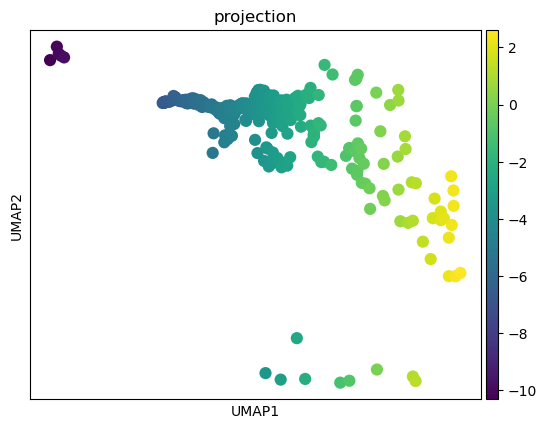

In [3]:
direction = np.array([1, 0])
adata.obs["projection"] = adata.obsm["X_umap"] @ direction
sc.pl.umap(adata, color='projection')

Here are correlations onto both the true projection coordinates and a randomly permuted version of those coordinates. Under the null, the gene's expression level doesn't vary according to the projection coordinate. More formally, we assume that under the null the distribution of the test statistic (in this case, the correlation) is invariant to permutations of the projection variable.

In [4]:
import pandas as pd

ix = np.random.permutation(len(adata))
adata.obs["projection_permuted"] = adata.obs["projection"].values[ix]

rho_df = pd.DataFrame({
    'gene': adata.var_names,
    'true': ctl.cormat(adata.X, adata.obs["projection"]),
    'control': ctl.cormat(adata.X, adata.obs["projection_permuted"])
    })

Let's plot the observed vs. control correlation values across all genes for this
single permutation. We have more evidence for effects when the gene's observed
correlation is larger in magnitude than any of the permutation-based
correlations. For this particular direction, there are quite a few genes whose
expression has a strong positive or negative correlation with the projection
direction.

In [5]:
import altair as alt

alt.Chart(rho_df).transform_fold(
    ['true', 'control'],
    as_=['variable', 'value']
).mark_bar(opacity=0.8).encode(
    alt.X('value:Q', bin=alt.Bin(maxbins=50)),
    alt.Y('count()').stack(None),
    alt.Color('variable:N')
)

alt.Chart(...)

### Selection Procedure

Our basic procedure is based off Jessica's Clipper algorithm. This computes contrast scores for each gene, defined here as a kind of difference between absolute correlations on real and a few (we use 5) permuted version of the data. Positive values mean that the observed correlation was larger than the permuted correlations, and larger positive values means that the difference was larger. Negative values mean that one of the permuted data correlations was larger than the real data correlations. It's possible to choose a cutoff so that the selected set will control the false discovery rate.

We could alternatively return permutation p-values, but this will require computing many permutations for each brush. On this dataset, this isn't such a big problem. I imagine for a larger dataset, we might run into issues (though, even there, we could subsample?). This is something we may want to revisit. The question comes down to: (1) Does this approach have sufficient power? (2) Are the contrast statistics too much more difficult to interpret?

In [6]:
scores = ctl.contrast_scores(adata.X, adata.obsm["X_umap"] @ direction)
scores_df = pd.DataFrame({"gene": adata.var_names, "score": scores})

The histogram below shows some of the contrast scores. Genes lying on the right hand tail likely have real signal. The genes on the left hand side give us a sense of the behavior of these statistics under the null (if everything were null, this distribution would be symmetric around 0).

In [7]:
alt.Chart(scores_df).mark_bar().encode(
    alt.X('score', bin=alt.Bin(maxbins=50)),
    y='count()'
)

alt.Chart(...)

The selection procedure computes an estimate of the false discovery proportion for every single gene. The final selection is defined as the last time any of the estimated false discovery proportions fall below the selection threshold; this is exactly analogous to the benjamini-hochberg procedure. In the plot below, we select every gene that's orange. It's normal for the curve to increase a bit at the end. Unfortunately, this means that the FDR estimates aren't that useful to show to anyone using sciviewer. If there are many associations, then some of the weak effects might actually have very low estimated FDRs (because the denominator has changed: more discoveries -> lower FDR).

In [8]:
fdr_hat, selection = ctl.false_discovery_estimate(scores, q=0.01)
scores_df["fdr"] = fdr_hat
scores_df["selection"] = selection

alt.Chart(scores_df)\
    .mark_point()\
    .encode(x='score', y='fdr', color='selection')

alt.Chart(...)

Even though we picked a random direction, we find quite a few associated genes. In retrospect, this makes sense. The UMAP is organizing cells according to gene expression values. Any direction will *have* to have associations with the gene expression values. This procedure will help us find which of the genes are contributing to the UMAP directions. I am a little worried that this means that this procedure will pick up on structure from UMAPs with totally random data. But this doesn't actually seem to be an issue. Switch the third block from `raw` to `python` to see what our results look like when using pure independent N(0, 1) data. There a small number of genes that have larger correlations than anything in the null -- and this might be a real bias -- but it is so small that it doesn't seem to have a chance of getting selected by the contrast statistics procedure.

In [9]:
scores_df["selection"].sum() / adata.n_vars

0.131

The plot below shows the top 10 genes according to contrast scores. The x-axis is the projection coordinate and the y-axis is expression. As hinted even in our initial histogram, there are quite a few genes with strong negative correlations; none with positive. The number in parenthesis for each panel is the contrast score. They're sorted from strongest to weakest effects.

In [10]:
scores_df = scores_df.sort_values("score", ascending=False)
ctl.plot_subset(adata, scores_df["gene"].values[:10], scores_df["score"].values[:10])

alt.FacetChart(...)

As a sanity check, here are 50 genes that don't pass the FDR threshold. They don't seem to have any systematic association.

In [11]:
alt.data_transformers.enable("vegafusion")
ctl.plot_subset(adata, scores_df["gene"].values[-50:], scores_df["score"].values[-50:])

alt.FacetChart(...)